# 1006개의 데이터로 Transfer_Learning 하기

- Densenet 모델 사용 + imagenet 가중치 프리즈
- 논문 모델의 FC layer를 수정하여 학습 (best_model_densenet_imagenet_256로 저장)
- 추후 densenet 모델 (imagenet 가중치) + FC layer(학습 가중치)를 진행
- 이때 Learning rate는 le-5 정도로 학습 (Densenet_Reconstruction_model.h5) 

## Step 1. 실험환경 set-up

#### 라이브러리 실행

In [1]:
from tensorflow.keras.models import Sequential, load_model

import os           
import numpy             as np  
import tensorflow        as tf
import matplotlib.pyplot as plt

#### 필요한 변수들 생성

In [3]:
IMAGE_SIZE = [1024, 1360]                  # 이미지 사이즈 변수
BATCH_SIZE = 32                            # BATCH_SIZE 변수
EPOCHS     = 150                           # EPOCH 크기 변수
AUTOTUNE   = tf.data.experimental.AUTOTUNE # 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수

#### GPU 사용 여부보기

In [4]:
gpus = tf.config.experimental.list_logical_devices("GPU")

if len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print(f"Running on multiple GPUs {[gpu.name for gpu in gpus]}")

elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy()
    print(f"Running on single GPU {gpus[0].name}")

else:
    strategy = tf.distribute.get_strategy()
    print("Running on CPU")

print(f"Number of accelerators: {strategy.num_replicas_in_sync}")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

## Step 2. 데이터 준비하기

먼저 아래의 링크에서 데이터를 다운 받을 것

https://drive.google.com/drive/folders/1Pi5qyX080zY2IdGT1TvvLraBO9DHBxJl?usp=sharing

받은 후 터미널 창에 아래의 명령어들을 차례로 입력

```
$ cd ~/Downloads && cp CellPin ~/aiffel
```

#### 데이터의 개수 확인

In [5]:
# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv("HOME"), "aiffel/CellPin")
print(ROOT_PATH)

# 각 데이터 불러오기
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + "/train/*/*"))
test_filenames  = tf.io.gfile.glob(str(ROOT_PATH + "/test/*/*"))
val_filenames   = tf.io.gfile.glob(str(ROOT_PATH + "/val/*/*"))

# 데이터 갯수 확인하기
print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

/home/mochafreddo/cellpin/CellPin
782
104
126


#### train 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [7]:
COUNT_NORMAL = len([filename for filename in train_filenames if "normal" in filename])
print("NORMAL images count in training set: " + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in train_filenames if "cpe" in filename])
print("CPE images count in training set: " + str(COUNT_CPE))

NORMAL images count in training set: 355
CPE images count in training set: 427


#### val 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [8]:
COUNT_NORMAL = len([filename for filename in val_filenames if "normal" in filename])
print("NORMAL images count in training set: " + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in val_filenames if "cpe" in filename])
print("CPE images count in training set: " + str(COUNT_CPE))

NORMAL images count in training set: 50
CPE images count in training set: 76


#### test 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [9]:
COUNT_NORMAL = len([filename for filename in test_filenames if "normal" in filename])
print("NORMAL images count in training set: " + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in test_filenames if "cpe" in filename])
print("CPE images count in training set: " + str(COUNT_CPE))

NORMAL images count in training set: 40
CPE images count in training set: 64


#### tf.data 인스턴스를 만들기

In [10]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds   = tf.data.Dataset.from_tensor_slices(val_filenames)

#### train data와 val data의 개수 확인

In [11]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 782
Validating images count: 126


#### 라벨 이름들 확인

In [12]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/train/*"))])
print(CLASS_NAMES)

['normal' 'cpe']


#### 라벨링 함수를 만들어 보기

In [13]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "cpe"

#### decode_img 함수와 process_path 함수를 만들기

In [14]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels = 1)
    
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
    
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    
    if label == True:
        label = ([0, 1])
    else:
        label = ([1, 0])
        
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    
    return img, label

#### train과 val에 함수들 적용해주기

In [15]:
train_ds = train_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
val_ds   = val_list_ds.map(process_path,   num_parallel_calls = AUTOTUNE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


#### 전처리 함수 만들기 및 적용

In [17]:
def prepare_for_training(ds, shuffle_buffer_size = 1000):
    ds = ds.shuffle(buffer_size = shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size = AUTOTUNE)

    return ds


train_ds = prepare_for_training(train_ds)
val_ds   = prepare_for_training(val_ds)

#### Image shape를 변경 체크하기

In [18]:
for image, label in train_ds.take(1):
    print("Image shape :", image.numpy().shape)
    print("Label :",       label.numpy().shape)

Image shape:  (32, 256, 256, 3)
Label:  (32, 2)


#### test 데이터 셋도 만들어 보기 & 데이터의 갯수 확인

In [19]:
test_list_ds     = tf.data.Dataset.list_files(str(ROOT_PATH + "/test/*/*"))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds          = test_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
test_ds          = test_ds.batch(BATCH_SIZE)
print(TEST_IMAGE_COUNT)

104


## Step 3. 데이터 시각화

#### 16개의 샘플 꺼내서 확인

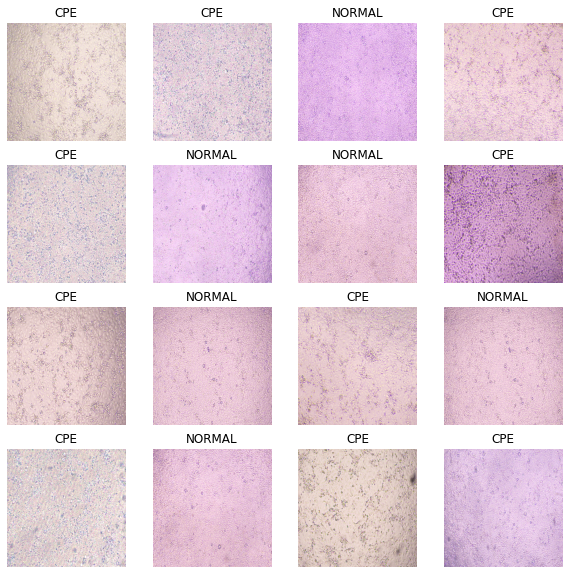

In [20]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize = (10,10))
    
    for n in range(16):
        ax = plt.subplot(4, 4, n + 1)
        plt.imshow(image_batch[n])
        
        if list(label_batch[n])[0].numpy() == 0:
            plt.title("CPE")
        else:
            plt.title("NORMAL")
        
        plt.axis("off")

        
show_batch(image_batch.numpy(), label_batch)

#### model building(DenseNet, Freeze)

In [21]:
with strategy.scope():
    # densenet에서 분류기를 제외한 부분을 가중치 있는 상태로 가져오기
    densenet_layer = tf.keras.applications.DenseNet201(include_top = False,
                                                       weights     = "imagenet",
                                                       input_shape = (256, 256, 3),
                                                       classes     = 2)
    # 제거된 분류기 만들기
    fc_layer = [
        tf.keras.layers.GlobalMaxPool2D(),
        tf.keras.layers.Dense(2),
        tf.keras.layers.Activation("softmax")
    ]
    
    # 가중치 있는 레이어를 학습 불가능 상태로 만들기
    densenet_layer.trainable = False
    
    # 두 레이어를 합쳐서 모델 만들기
    densenet = tf.keras.models.Sequential([densenet_layer] + fc_layer)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [23]:
densenet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 8, 8, 1920)        18321984  
_________________________________________________________________
global_max_pooling2d (Global (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 3842      
_________________________________________________________________
activation (Activation)      (None, 2)                 0         
Total params: 18,325,826
Trainable params: 3,842
Non-trainable params: 18,321,984
_________________________________________________________________


## Step 4. 모델 훈련

#### GPU사용하여 model complie

In [25]:
with strategy.scope():
    METRICS = [
        "accuracy",
        tf.keras.metrics.Precision(name = "precision"),
        tf.keras.metrics.Recall(name    = "recall")
    ]
    
    densenet.compile(
        optimizer = "adam",
        loss      = "binary_crossentropy",
        metrics   = METRICS
    )
    
    check_point = tf.keras.callbacks.ModelCheckpoint('best_model_densenet_imagenet_FC_FT_1.h5')

#### 모델 fitting

In [27]:
with strategy.scope():
    history = densenet.fit(
        train_ds,
        steps_per_epoch  = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs           = EPOCHS,
        validation_data  = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        callbacks        = [check_point]
    )

Epoch 1/150
INFO:tensorflow:batch_all_reduce: 2 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 2 all-reduces with algorithm = nccl, num_packs = 1
24/24 [==============================] - 60s 1s/step - loss: 0.6797 - accuracy: 0.6042 - precision: 0.6042 - recall: 0.6042 - val_loss: 0.4356 - val_accuracy: 0.8750 - val_precision: 0.8750 - val_recall: 0.8750
Epoch 2/150
24/24 [==============================] - 16s 697ms/step - loss: 0.3436 - accuracy: 0.9044 - precision: 0.9044 - recall: 0.9044 - val_loss: 0.3414 - val_accuracy: 0.8750 - val_precision: 0.8750 - val_recall: 0.8750
Epoch 3/150
24/24 [==============================] - 16s 712ms/step - loss: 0.2677 - accuracy: 0.9163 - precision: 0.9163 - recall: 0.9163 - val_loss: 0.2488 - val_accuracy: 0.9375 - val_precision: 0.9375 - val_recall: 0.9375
Epoch 4/150
24/24 [==============================] - 15s 631ms/step - loss: 0.2302 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312 - val_loss: 0.26

24/24 [==============================] - 14s 621ms/step - loss: 0.0309 - accuracy: 0.9998 - precision: 0.9998 - recall: 0.9998 - val_loss: 0.1201 - val_accuracy: 0.9583 - val_precision: 0.9583 - val_recall: 0.9583
Epoch 73/150
24/24 [==============================] - 14s 624ms/step - loss: 0.0278 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2157 - val_accuracy: 0.9271 - val_precision: 0.9271 - val_recall: 0.9271
Epoch 74/150
24/24 [==============================] - 14s 598ms/step - loss: 0.0252 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1728 - val_accuracy: 0.9375 - val_precision: 0.9375 - val_recall: 0.9375
Epoch 75/150
24/24 [==============================] - 14s 623ms/step - loss: 0.0285 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1460 - val_accuracy: 0.9375 - val_precision: 0.9375 - val_recall: 0.9375
Epoch 76/150
24/24 [==============================] - 14s 603ms/step - loss: 0.0223 - accuracy: 1.0000 - 

Epoch 144/150
24/24 [==============================] - 14s 602ms/step - loss: 0.0083 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2159 - val_accuracy: 0.9271 - val_precision: 0.9271 - val_recall: 0.9271
Epoch 145/150
24/24 [==============================] - 14s 602ms/step - loss: 0.0080 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2138 - val_accuracy: 0.9271 - val_precision: 0.9271 - val_recall: 0.9271
Epoch 146/150
24/24 [==============================] - 14s 613ms/step - loss: 0.0063 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0693 - val_accuracy: 0.9688 - val_precision: 0.9688 - val_recall: 0.9688
Epoch 147/150
24/24 [==============================] - 14s 598ms/step - loss: 0.0091 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1556 - val_accuracy: 0.9479 - val_precision: 0.9479 - val_recall: 0.9479
Epoch 148/150
24/24 [==============================] - 14s 627ms/step - loss: 0.0074 - a

## Step 5. 결과 확인 및 시각화

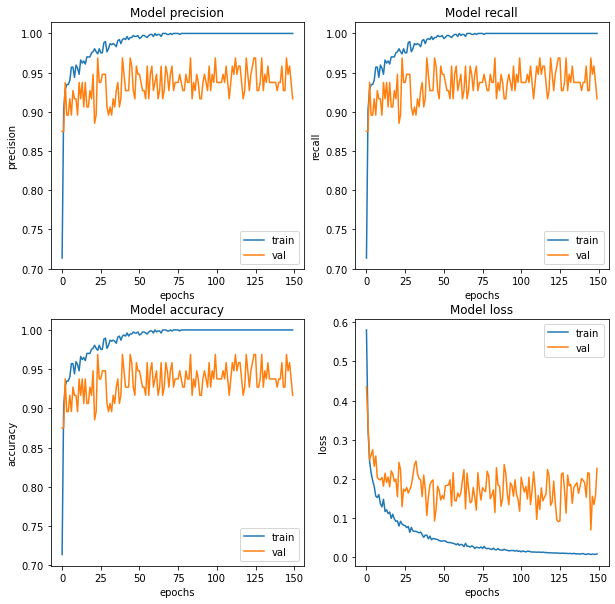

In [28]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax      = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title(f"Model {met}")
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

## Step 6. 최종 Test dataset 검정하기

In [29]:
with strategy.scope():
    model_densenet = tf.keras.models.load_model("best_model_densenet_imagenet_FC_FT_1.h5")
    
    loss, acc, prec, rec = model_densenet.evaluate(test_ds)

4/4 [==============================] - 10s 280ms/step - loss: 0.1254 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615


## Step 9. Fine Tunning

In [ ]:
# unfreeze
with strategy.scope():
    model_densenet.layers[0].trainable = True

In [38]:
model_densenet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 8, 8, 1920)        18321984  
_________________________________________________________________
global_max_pooling2d (Global (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 3842      
_________________________________________________________________
activation (Activation)      (None, 2)                 0         
Total params: 18,325,826
Trainable params: 18,096,770
Non-trainable params: 229,056
_________________________________________________________________


In [45]:
with strategy.scope():
    
    densenet = tf.keras.models.load_model("best_model_densenet_imagenet_FC_FT_1.h5")
    
    densenet.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
        loss      = "binary_crossentropy",
        metrics   = METRICS
    )
    
    check_point = tf.keras.callbacks.ModelCheckpoint("Densenet_Reconstruction_model_FC_FT.h5")

In [47]:
with strategy.scope():
    history = densenet.fit(
        train_ds,
        steps_per_epoch  = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs           = EPOCHS,
        validation_data  = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        callbacks        = [check_point]
    )

Epoch 1/150
INFO:tensorflow:batch_all_reduce: 2 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 2 all-reduces with algorithm = nccl, num_packs = 1
24/24 [==============================] - 54s 1s/step - loss: 0.0061 - accuracy: 1.0000 - precision: 0.9843 - recall: 0.9843 - val_loss: 0.2222 - val_accuracy: 0.9271 - val_precision: 0.9271 - val_recall: 0.9271
Epoch 2/150
24/24 [==============================] - 16s 696ms/step - loss: 0.0071 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1066 - val_accuracy: 0.9688 - val_precision: 0.9688 - val_recall: 0.9688
Epoch 3/150
24/24 [==============================] - 16s 689ms/step - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2319 - val_accuracy: 0.9167 - val_precision: 0.9167 - val_recall: 0.9167
Epoch 4/150
24/24 [==============================] - 17s 723ms/step - loss: 0.0063 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.13

24/24 [==============================] - 14s 608ms/step - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1179 - val_accuracy: 0.9583 - val_precision: 0.9583 - val_recall: 0.9583
Epoch 73/150
24/24 [==============================] - 14s 621ms/step - loss: 0.0058 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1922 - val_accuracy: 0.9271 - val_precision: 0.9271 - val_recall: 0.9271
Epoch 74/150
24/24 [==============================] - 14s 611ms/step - loss: 0.0064 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1900 - val_accuracy: 0.9271 - val_precision: 0.9271 - val_recall: 0.9271
Epoch 75/150
24/24 [==============================] - 14s 611ms/step - loss: 0.0060 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1953 - val_accuracy: 0.9271 - val_precision: 0.9271 - val_recall: 0.9271
Epoch 76/150
24/24 [==============================] - 14s 618ms/step - loss: 0.0062 - accuracy: 1.0000 - 

Epoch 144/150
24/24 [==============================] - 14s 626ms/step - loss: 0.0064 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1708 - val_accuracy: 0.9375 - val_precision: 0.9375 - val_recall: 0.9375
Epoch 145/150
24/24 [==============================] - 14s 614ms/step - loss: 0.0072 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1715 - val_accuracy: 0.9479 - val_precision: 0.9479 - val_recall: 0.9479
Epoch 146/150
24/24 [==============================] - 14s 599ms/step - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1412 - val_accuracy: 0.9479 - val_precision: 0.9479 - val_recall: 0.9479
Epoch 147/150
24/24 [==============================] - 14s 606ms/step - loss: 0.0069 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1626 - val_accuracy: 0.9479 - val_precision: 0.9479 - val_recall: 0.9479
Epoch 148/150
24/24 [==============================] - 14s 602ms/step - loss: 0.0056 - a

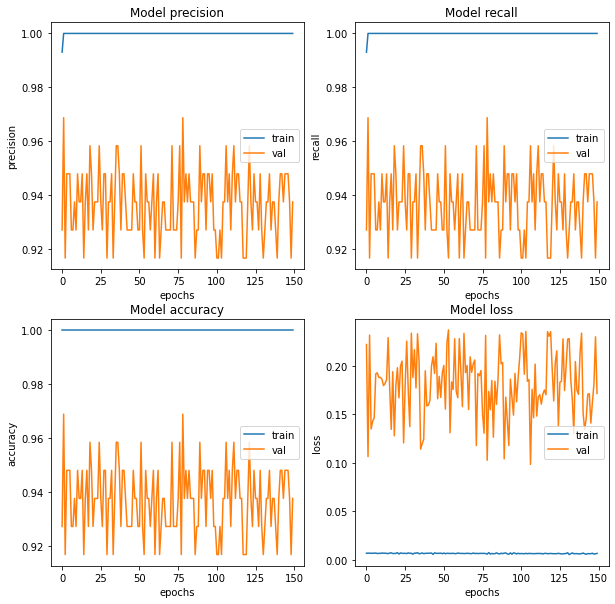

In [48]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax      = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title(f"Model {met}")
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [49]:
with strategy.scope():
    model_densenet = tf.keras.models.load_model("Densenet_Reconstruction_model_FC_FT.h5")
    
    loss, acc, prec, rec = model_densenet.evaluate(test_ds)

4/4 [==============================] - 5s 208ms/step - loss: 0.1267 - accuracy: 0.9615 - precision: 0.9615 - recall: 0.9615
